In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Dataset load

In [2]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformer, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformer, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.98MB/s]


In [4]:
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False)

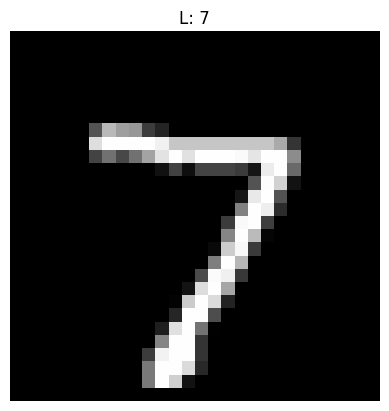

In [5]:
for img, label in test_loader:
  # img = img[0].transpose((1, 2, 0))
  img = img[0].numpy()
  img = img.transpose((1, 2, 0))
  plt.imshow(img, cmap='gray')
  plt.title(f'L: {label[0]}')
  plt.axis('off')
  plt.show()
  break

## Build LeNet5 and Train the model

In [6]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2) # 28x28 -> 28x28
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 14x14 -> 10x10
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(x.size(0), -1) # Flatten the image
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [15]:
# Model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
# Train Loop
epochs = 10
train_loss, test_accuracy = [], []

for epoch in range(epochs):
  # Train
  model.train()
  running_loss = 0.0
  for img, label in train_loader:
    optimizer.zero_grad()
    img, label = img.to(device), label.to(device)
    out = model(img)

    loss = loss_func(out, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  total_loss = running_loss/len(train_loader)
  train_loss.append(total_loss)
  print(f'Epoch [{epoch + 1}/{epochs}], loss: {total_loss}')

  # Evaluate
  model.eval()
  correct, total = 0, 0
  for img, label in test_loader:
    img, label = img.to(device), label.to(device)
    with torch.no_grad():
      predict = model(img)
      p_label = torch.argmax(predict, 1)
      total += label.size(0)
      correct += (p_label==label).sum().item()

  acc = 100.0 * correct / total
  test_accuracy.append(acc)
  print(f'Accuracy: {acc}')

Epoch [1/10], loss: 0.16070830880866074
Accuracy: 98.2
Epoch [2/10], loss: 0.09056030040813008
Accuracy: 97.35
Epoch [3/10], loss: 0.09070179666165738
Accuracy: 97.53
Epoch [4/10], loss: 0.07432345405700308
Accuracy: 97.95
Epoch [5/10], loss: 0.07779175557567851
Accuracy: 97.92
Epoch [6/10], loss: 0.07502559312622835
Accuracy: 98.23
Epoch [7/10], loss: 0.07402351689616504
Accuracy: 98.11
Epoch [8/10], loss: 0.0679004464515048
Accuracy: 98.45
Epoch [9/10], loss: 0.06774835458827548
Accuracy: 98.26
Epoch [10/10], loss: 0.05771150875825219
Accuracy: 98.18


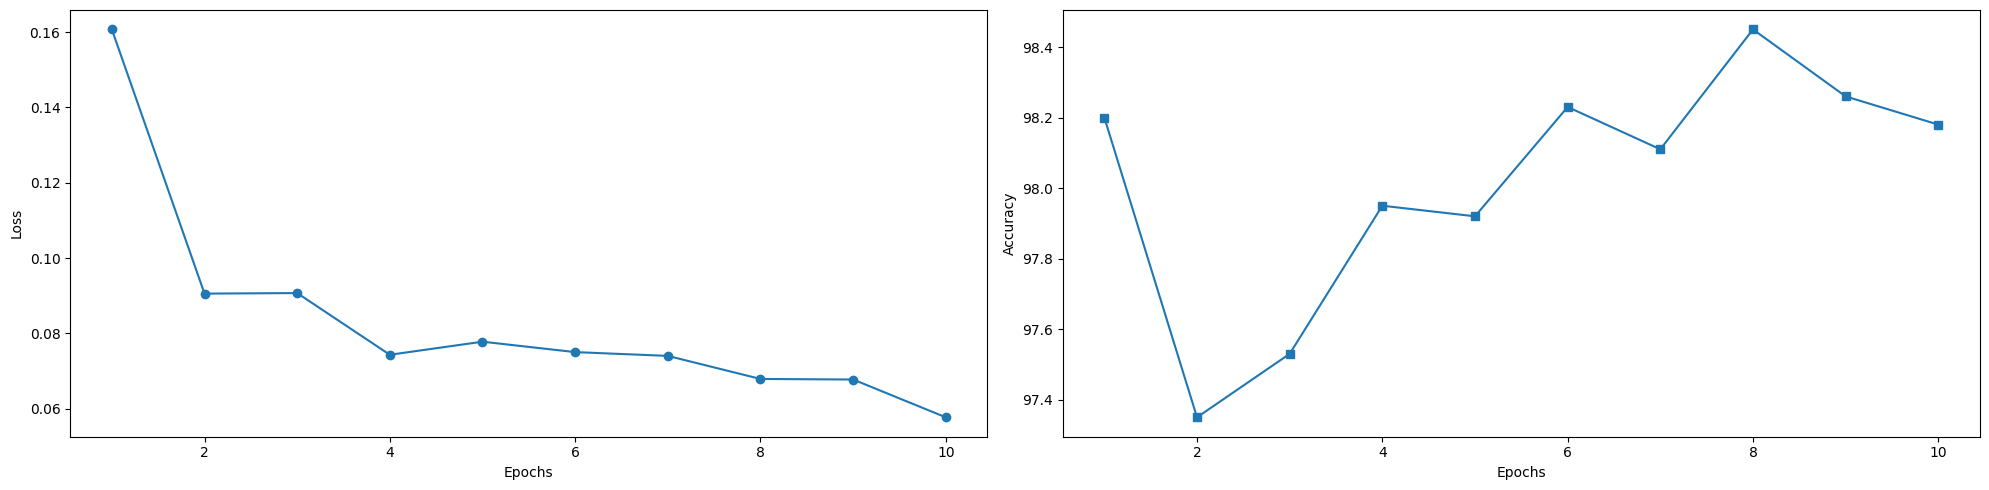

In [21]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), test_accuracy, marker='s', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()